<a href="https://colab.research.google.com/github/agojunior/cap-423/blob/main/PivosCentrais/NotebooksPivos/Hough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
from shapely.geometry import Point
from timeit import default_timer as timer
import sys

def auto_canny(image, sigma=0.33):
    v = np.ma.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    start = timer()
    edged = cv2.Canny(image, lower, upper)
    end = timer()
    print("Edged in: ", end - start, " seconds.")
    print('median:', v, 'lower:', lower, ' upper:', upper)
    return edged

def norm_minmax(array, min_val, max_val):
    return (array - array.min()) / (array.max() - array.min()) * (max_val - min_val) + min_val

def filter_overlapping_circles(circles):
    """Remove overlapping circles, keeping only the larger ones."""
    if circles is None:
        return []

    filtered = []
    for i, circle in enumerate(circles):
        x1, y1, r1 = circle.astype(np.float32)  # Convert to float to prevent overflow
        keep = True
        for j, other_circle in enumerate(circles):
            if i == j:
                continue
            x2, y2, r2 = other_circle.astype(np.float32)  # Convert to float to prevent overflow
            distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            if distance < r1 + r2 and r1 < r2:
                keep = False
                break
        if keep:
            filtered.append(circle)
    return np.array(filtered)

# Path to the TIF file and Shapefile output
# Argument parsing
# if len(sys.argv) != 2:
#     print("Usage: python Hough_updated.py <path_to_tif_file>")
#     sys.exit(1)

# tif_path = sys.argv[1]
tif_path = '/content/S2-16D_V2_020018_20170101_NDVI.tiff'
shapefile_output_path = '/content/detected_circles.shp'

# Read the NDVI image
with rasterio.open(tif_path) as src:
    array_ndvi = src.read(1)
    transform = src.transform  # Affine transform for georeferencing

# Normalize the array to 0-255 and squeeze dimensions for processing
array = np.uint8(norm_minmax(array_ndvi, 0, 255))

# Apply morphological erosion
kernel = np.ones((3, 3), np.uint8)
erosion = cv2.erode(array, kernel, iterations=1)
array = erosion
cv2.GaussianBlur(array, (9, 9), 0)
edges = auto_canny(array, sigma=0.33)
# edges[(array_ndvi <= 0.44)] = 0
# Detect circles using Hough Transform
circulos = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=1,
                            param1=50, param2=15, minRadius=40, maxRadius=110)

# Filter overlapping circles
if circulos is not None:
    circulos = np.uint16(np.around(circulos[0]))  # Extract circle parameters
    circulos = filter_overlapping_circles(circulos)

# Save circles to a shapefile
if circulos is not None:
    geometries = []
    attributes = []
    for x, y, r in circulos:
        # Transform pixel coordinates to geographic coordinates
        lon, lat = rasterio.transform.xy(transform, y, x, offset='center')
        geometries.append(Point(lon, lat))
        attributes.append({'radius': r})

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(attributes, geometry=geometries, crs="EPSG:4326")
    gdf.to_file(shapefile_output_path)
    print(f"Detected circles saved to: {shapefile_output_path}")

# Draw the detected circles
imagem_circulos = cv2.cvtColor(array, cv2.COLOR_GRAY2BGR)  # Convert to BGR for colored circles
if circulos is not None:
    for x, y, r in circulos:
        # Draw outer circle in red
        cv2.circle(imagem_circulos, (x, y), r, (0, 0, 255), 2)
        # Draw circle center in red
        cv2.circle(imagem_circulos, (x, y), 2, (0, 0, 255), 3)

# Count the number of detected circles
numero_de_pivos = len(circulos) if circulos is not None else 0

# Display the results with larger images
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title('Imagem Original')
plt.imshow(array, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Detecção de Pivôs de Irrigação')
plt.imshow(cv2.cvtColor(imagem_circulos, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis('off')
plt.show()

# Print the number of detected pivots
print(f"Número de pivôs detectados: {numero_de_pivos}")

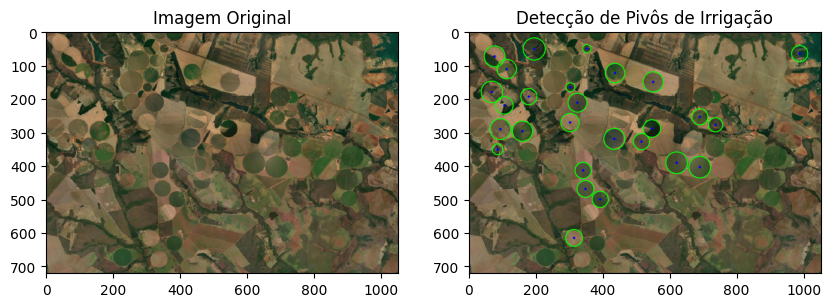

Número de pivôs detectados: 27


In [ ]:
# Carregar a imagem de satélite
imagem = cv2.imread('pivo_cristalina.png')
imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

# Suavizar a imagem para reduzir ruídos
imagem_suavizada = cv2.GaussianBlur(imagem_cinza, (9, 9), 0)

# Detectar círculos usando a Transformada de Hough
circulos = cv2.HoughCircles(imagem_suavizada, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
                            param1=100, param2=30, minRadius=5, maxRadius=70)

# Desenhar os círculos detectados
imagem_circulos = imagem_rgb.copy()
if circulos is not None:
    circulos = np.uint16(np.around(circulos))
    for i in circulos[0, :]:
        cv2.circle(imagem_circulos, (i[0], i[1]), i[2], (0, 255, 0), 2)
        cv2.circle(imagem_circulos, (i[0], i[1]), 2, (0, 0, 255), 3)

# Mostrar imagem original e resultado
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Imagem Original')
plt.imshow(imagem_rgb)
plt.subplot(1, 2, 2)
plt.title('Detecção de Pivôs de Irrigação')
plt.imshow(imagem_circulos)
plt.show()

# Contar o número de pivôs detectados
numero_de_pivos = len(circulos[0]) if circulos is not None else 0
print(f"Número de pivôs detectados: {numero_de_pivos}")
